In [1434]:
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import beta

import matplotlib as mpl

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

import strategymodels

from Functions.set_Beta_prior import set_priors
from Functions.Summaries_of_Beta_distribution import summaries_of_Beta_Distribution

prior_type = "Uniform" 

plt.rcParams['font.sans-serif'] = ['Tahoma', 'DejaVu Sans',
                               'Lucida Grande', 'Verdana']


In [1435]:

trial_data = pd.DataFrame(columns=["TargetRule", "Choice", "CuePosition", "Reward"])
rules = ['go_left', 'go_right']
rules = ['go_left', 'go_cued', 'go_right', 'go_uncued']
choices = ["left", "right", "cued_arm", "uncued_arm"]
cue_positions = ["left", "right"]

number_of_trials = 10000
decay_rate_baseline_gamma = 0.03
num_of_rules = len(rules)

consecutive_successes = 0
current_rule = 0
strategy_switches = []

total_reward = 0
total_rewards_per_arm = [0] * num_of_rules
selections_per_arm = [0] * num_of_rules
trial_type = [""] * len(rules)

prob_reward_success = 0.8

map_per_arm = [[] for _ in range(num_of_rules)]

In [1436]:
class ThompsonSamplingAgent():
    
    def __init__(self, num_of_rules, num_of_trials, decay_rate_gamma, alpha0=set_priors(prior_type)[0], beta0=set_priors(prior_type)[1]):

        self.num_of_rules = num_of_rules
        self.num_of_trials = num_of_trials
        self.decay_rate_baseline_gamma = decay_rate_gamma
        self.decay_rate_gamma = np.zeros(num_of_trials)
        self.decay_rate_gamma[0] = decay_rate_baseline_gamma

        self.alphas, self.betas = np.ones((num_of_trials, num_of_rules)), np.ones((num_of_trials, num_of_rules))
        self.alphas[0], self.betas[0] = alpha0, beta0

        self.map_per_arm = [[] for _ in range(num_of_rules)]

        self.cumilative_regret = np.zeros(num_of_trials)

        self.init_pe()
        self.init_meta()

    def init_pe(self):

        self.prediction_error = np.zeros(self.num_of_trials)

        self.smoothing_lambda = 0.8
        self.sensitivity_kappa_initial = 0.3
        self.sensitivity_kappa = self.sensitivity_kappa_initial
    
    def init_meta(self):

        self.learning_rate_initial = 0.01
        self.learning_rate = self.learning_rate_initial
        self.reversal_regret = []
        self.regret_gradients = []

    def add_reversal_regret(self, regret, trial):
        self.reversal_regret.append([trial, regret])
    
    def set_decay_rate_gamma(self, trial, gamma):
        self.decay_rate_gamma[trial] = gamma

    def get_samples(self, trial):

        self.samples = [np.random.beta(self.alphas[trial, rule], self.betas[trial, rule]) for rule in range(self.num_of_rules)]
        return self.samples
    
    def pick_action(self):
        return np.argmax(self.samples)

    def update_posterior(self, trial, choice, reward):

        if(trial < self.num_of_trials-1):

            self.alphas[trial+1], self.betas[trial+1] = self.alphas[trial], self.betas[trial]
            self.alphas[trial+1, choice] = self.alphas[trial, choice] * (1 - self.decay_rate_gamma[trial]) + self.decay_rate_gamma[trial] * self.alphas[0, 0] + reward[choice]
            self.betas[trial+1, choice] = self.betas[trial, choice] * (1 - self.decay_rate_gamma[trial]) + self.decay_rate_gamma[trial] * self.betas[0, 0] + (1 - reward[choice])

            self.decay_rate_gamma[trial+1] = self.decay_rate_gamma[trial]

    def pe_update_gamma(self, trial, choice, reward, expected_reward):

        error = np.abs(reward[choice] - expected_reward)
        if(trial > 0): 
            self.prediction_error[trial] = self.smoothing_lambda * self.prediction_error[trial-1] + \
                                                            (1 - self.smoothing_lambda) * error
        
        if(trial < self.num_of_trials-1):

            self.decay_rate_gamma[trial+1] = np.clip(self.decay_rate_baseline_gamma * np.exp(self.sensitivity_kappa * self.prediction_error[trial]), 0, 1)
            # print(self.decay_rate_gamma[trial])
        
        self.sensitivity_kappa = self.sensitivity_kappa_initial * np.exp(-0.001 * trial)

    def update_learning_rate(self, trial):
        self.learning_rate = self.learning_rate_initial * np.exp(-0.0001 * trial)

    def meta_update_gamma(self, trial, reversal):
        
        if(trial < self.num_of_trials-1):
            self.decay_rate_gamma[trial+1] = np.clip(self.decay_rate_gamma[trial] + self.learning_rate * (self.reversal_regret[reversal][1] - self.reversal_regret[reversal-1][1]), 0, 1)
            self.regret_gradients.append([trial, abs(self.reversal_regret[reversal][1] - self.reversal_regret[reversal-1][1])])
            # print(self.decay_rate_gamma[trial])

        self.update_learning_rate(trial)

    def update_distribution_map(self, trial):
        
        for rule in range(self.num_of_rules):
            a, b = self.alphas[trial, rule], self.betas[trial, rule]

            self.map_per_arm[rule].append(summaries_of_Beta_Distribution(a, b, 'MAP'))
        
    def calculate_regret(self, trial, choice, trial_type, reversal):
        
        prob_optimal = prob_reward_success
        prob_observed = prob_reward_success if(trial_type == "success") else 1-prob_reward_success

        regret = prob_optimal - prob_observed

        if(trial == 0 or reversal): self.cumilative_regret[trial] = regret
        else: self.cumilative_regret[trial] = self.cumilative_regret[trial-1] + regret

        return self.cumilative_regret

In [1437]:
agent = ThompsonSamplingAgent(num_of_rules=num_of_rules, 
                              num_of_trials=number_of_trials, 
                              decay_rate_gamma=decay_rate_baseline_gamma
                              )

current_reversal = 0
reversal = False

for trial in range(number_of_trials):

    cued_hand = np.random.randint(0,2)
    reward = np.zeros(num_of_rules)

    samples = agent.get_samples(trial)
    choice = agent.pick_action()
    update_choice = choice
    
    if(choice == choices.index("cued_arm")):
        choice = cued_hand
    if(choice == choices.index("uncued_arm")):
        choice = 1 - cued_hand

    trial_data = pd.concat([trial_data, 
                            pd.DataFrame({"TargetRule": rules[current_rule], 
                                        "Choice": choices[choice], 
                                        "CuePosition": cue_positions[cued_hand],
                                        "Reward": None}, index=[trial])])
    
    rows_of_data = trial_data.iloc[0:trial+1] 

    for idx, rule in enumerate(rules):
       
       strategy_fcn = getattr(strategymodels, rule)  
       trial_type[idx] = strategy_fcn(rows_of_data)   

    if trial_type[current_rule] == "success":
        reward[update_choice] = np.random.binomial(1, prob_reward_success) 
        consecutive_successes += 1
    else:
        reward[update_choice] = np.random.binomial(1, 1-prob_reward_success) 
        consecutive_successes = 0

    trial_data.at[trial, "Reward"] = reward[update_choice]
    total_reward += reward

    agent.update_posterior(trial, update_choice, reward)
    # agent.pe_update_gamma(trial, update_choice, reward, 1 if trial_type[current_rule] == "success" else 0)
    regret = agent.calculate_regret(trial, update_choice, trial_type[current_rule], reversal)
    reversal = False

    if consecutive_successes == 10:
        current_rule += 1

        agent.add_reversal_regret(regret[trial], trial)
        # if(current_reversal != 0):
        #     agent.meta_update_gamma(trial, current_reversal)
        current_reversal += 1
        reversal = True

        consecutive_successes = 0
        if(current_rule == num_of_rules):
            current_rule = 0
        strategy_switches.append((trial, rules[current_rule]))
    
    agent.update_distribution_map(trial)


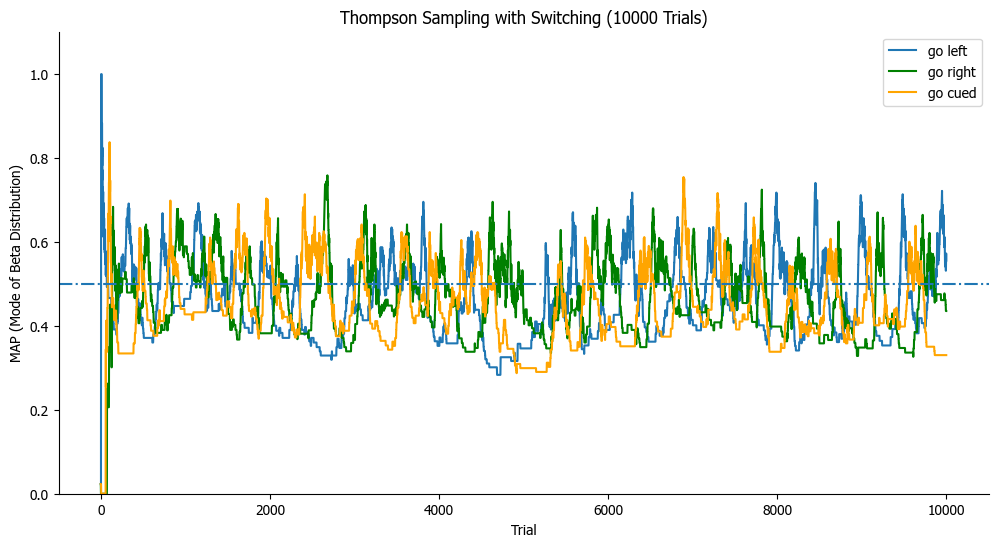

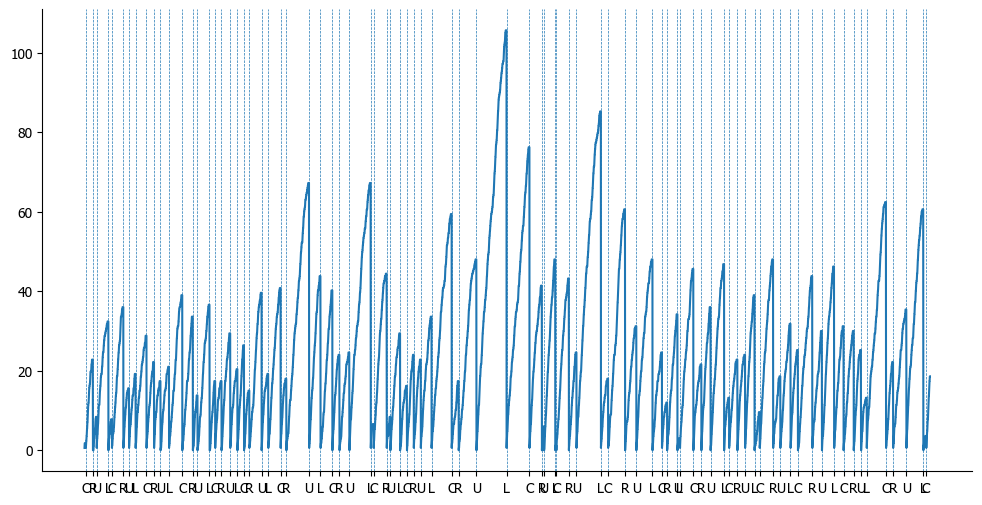

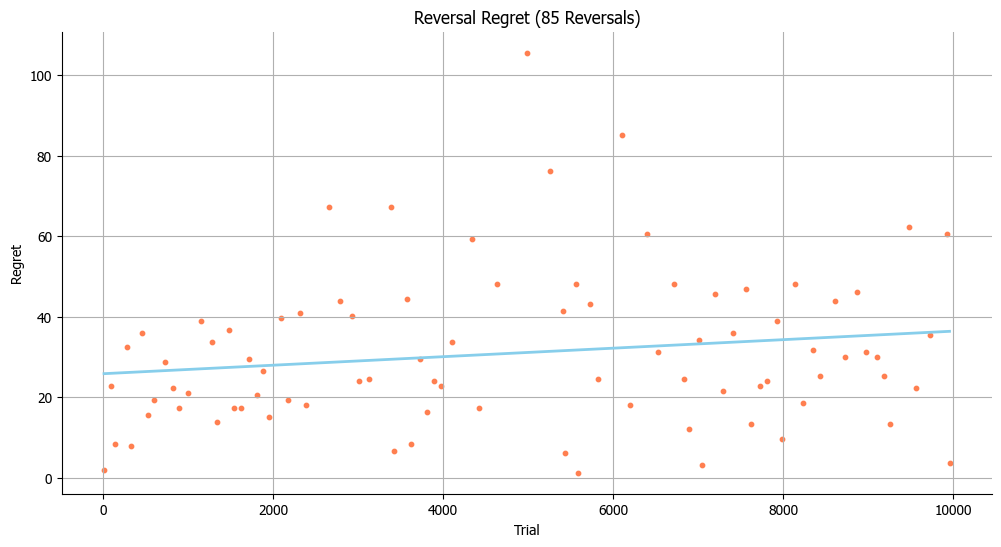

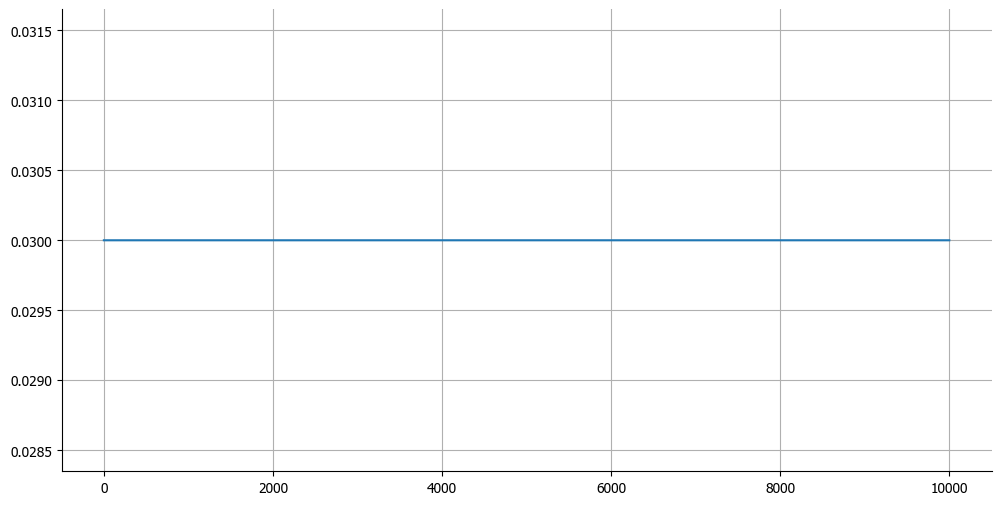

In [1438]:
def switch_label(rule):
    return rule.split("_")[1][0].upper()

plt.figure(figsize=(12, 6))
plt.plot(agent.map_per_arm[0], label='go left')
plt.plot(agent.map_per_arm[1], label='go right', color="green")
plt.plot(agent.map_per_arm[2], label='go cued', color="orange") 
# plt.plot(map_per_arm[3], label='Uncued')
plt.title(f'Thompson Sampling with Switching ({number_of_trials} Trials)')
plt.xlabel('Trial')
plt.ylabel('MAP (Mode of Beta Distribution)')
plt.ylim(0, 1.1)
plt.axhline(y=0.5, linestyle="dashdot")
plt.legend()
plt.grid(False)

# plt.draw()
# bottom_xlim = plt.xlim()

# if strategy_switches:
#     top_ax = plt.twiny() 
#     top_ax.set_xlim(bottom_xlim)
#     switch_positions = [switch[0] for switch in strategy_switches]
#     switch_labels = [switch_label(switch[1]) for switch in strategy_switches]
#     top_ax.set_xticks(switch_positions)
#     top_ax.set_xticklabels(switch_labels)
#     top_ax.set_xlabel("Strategy Phase")
#     for switch in strategy_switches:
#         plt.axvline(x=switch[0], linestyle="--", lw=0.5)
#     plt.xticks(
#         [switch[0] for switch in strategy_switches],
#         [switch_label(switch[1]) for switch in strategy_switches]
#     )


plt.show()

plt.figure(figsize=(12, 6))
plt.plot(regret)

if strategy_switches:
    for switch in strategy_switches:
        plt.axvline(x=switch[0], linestyle="--", lw=0.5)
    plt.xticks(
        [switch[0] for switch in strategy_switches],
        [switch_label(switch[1]) for switch in strategy_switches]
    )

plt.show()

x = np.array([i[0] for i in agent.reversal_regret])
y = np.array([i[1] for i in agent.reversal_regret])

coeffs = np.polyfit(x, y, 1)  
y_fit = np.polyval(coeffs, x)

plt.figure(figsize=(12,6))
plt.scatter(x, y, s=10, color="coral",)
plt.plot(x, y_fit, color="skyblue", linewidth=2)
plt.title(f"Reversal Regret ({len(x)} Reversals)")
plt.xlabel("Trial")
plt.ylabel("Regret")
plt.grid(True)
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(agent.decay_rate_gamma)
plt.grid(True)
plt.show()



[(13, 'go_cued'), (98, 'go_right'), (144, 'go_uncued'), (282, 'go_left'), (324, 'go_cued'), (459, 'go_right'), (526, 'go_uncued'), (604, 'go_left'), (733, 'go_cued'), (822, 'go_right'), (898, 'go_uncued'), (999, 'go_left'), (1156, 'go_cued'), (1280, 'go_right'), (1336, 'go_uncued'), (1478, 'go_left'), (1545, 'go_cued'), (1620, 'go_right'), (1723, 'go_uncued'), (1808, 'go_left'), (1886, 'go_cued'), (1949, 'go_right'), (2094, 'go_uncued'), (2172, 'go_left'), (2319, 'go_cued'), (2386, 'go_right'), (2655, 'go_uncued'), (2790, 'go_left'), (2931, 'go_cued'), (3014, 'go_right'), (3131, 'go_uncued'), (3384, 'go_left'), (3419, 'go_cued'), (3573, 'go_right'), (3617, 'go_uncued'), (3732, 'go_left'), (3812, 'go_cued'), (3894, 'go_right'), (3977, 'go_uncued'), (4104, 'go_left'), (4342, 'go_cued'), (4425, 'go_right'), (4634, 'go_uncued'), (4991, 'go_left'), (5262, 'go_cued'), (5408, 'go_right'), (5435, 'go_uncued'), (5567, 'go_left'), (5580, 'go_cued'), (5728, 'go_right'), (5818, 'go_uncued'), (6107

/var/folders/z1/sgn9t71x64jdbqjq0rlvj2gh0000gn/T/ipykernel_75399/1253194870.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


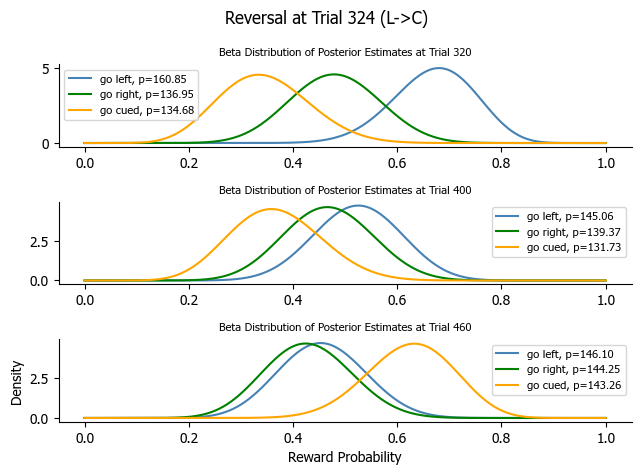

In [1439]:
x = np.linspace(0, 1, 1000)  # Probability range

colors = ["steelblue", "green", "orange"]
rules = ["go left", "go right", "go cued"]
trials = [320, 400, 460]

fig, axs = plt.subplots(3, 1)

for i, trial in enumerate(trials):
    for rule in range(agent.num_of_rules-1):
        a = agent.alphas[trial, rule]
        b = agent.betas[trial, rule]
        y = beta.pdf(x, a, b)

        var = (a * b) / ((a + b)**2 * (a + b + 1))
        precision = 1 / var

        axs[i].plot(x, y, label=f'{rules[rule]}, p={precision:.2f}', color=colors[rule])
        axs[i].set_title(f'Beta Distribution of Posterior Estimates at Trial {trial}', fontsize=8)
        axs[i].legend(fontsize="8")


fig.suptitle("Reversal at Trial 324 (L->C)")
axs[2].set_xlabel('Reward Probability')
axs[2].set_ylabel('Density')
fig.tight_layout()

fig.show()

print(strategy_switches)